🔥 正在审问 YOLO: best.pt
🚀 YOLO, 把你看到的所有东西都画出来！(Conf=0.01)
📊 YOLO 实际上看到了 300 个框。
✅ 证据已保存: yolo_interrogation_evidence.jpg


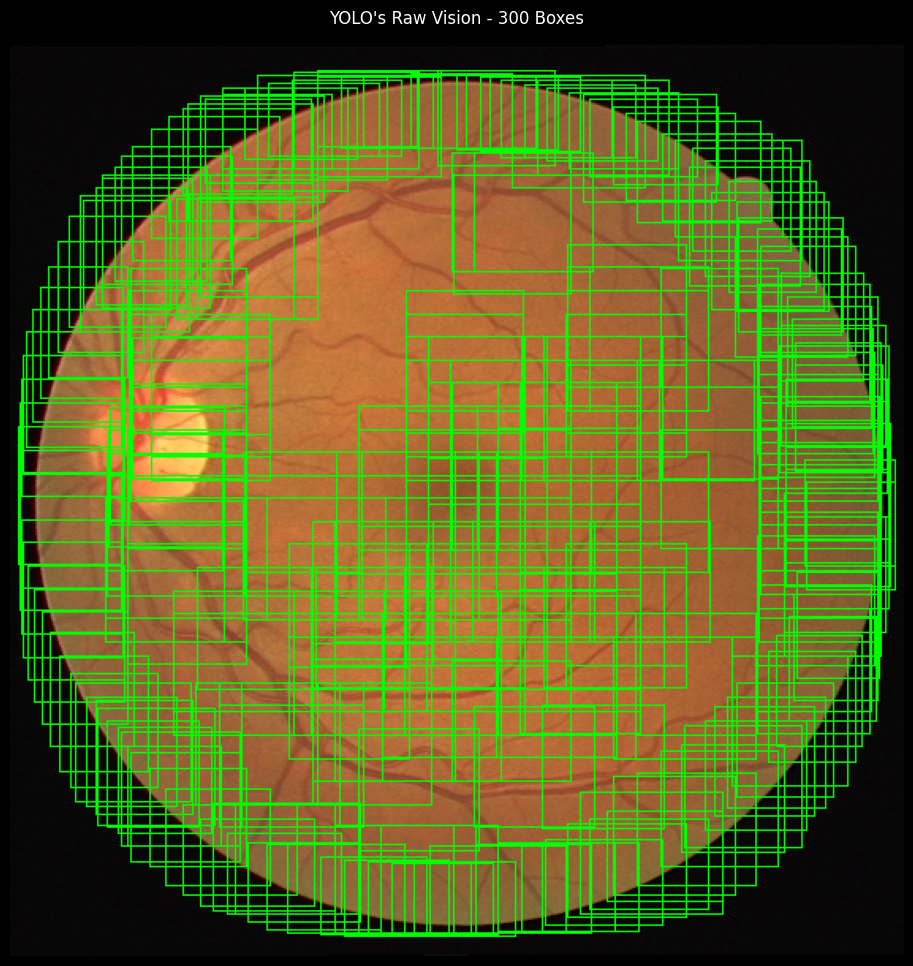

In [3]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import glob
import os

# 1. 加载模型
yolo_files = glob.glob("./runs/**/weights/best.pt", recursive=True)
best_yolo_path = max(yolo_files, key=os.path.getmtime)
yolo_model = YOLO(best_yolo_path)
print(f"🔥 正在审问 YOLO: {os.path.basename(best_yolo_path)}")

# 2. 读取图片
img_path = "../../../datasets/DRIVE/test/images/01_test.tif"
image = cv2.imread(img_path)

# 3. 原生预测
print("🚀 YOLO, 把你看到的所有东西都画出来！(Conf=0.01)")
results = yolo_model.predict(image, conf=0.01, verbose=False)

# 4. 手动画框 (不依赖任何库的智能可视化)
boxes = results[0].boxes.xyxy.cpu().numpy()
print(f"📊 YOLO 实际上看到了 {len(boxes)} 个框。")

# 在图片上画出所有框
for box in boxes:
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 1) # 用绿色细线画

# 5. 保存并展示证据
evidence_path = "yolo_interrogation_evidence.jpg"
cv2.imwrite(evidence_path, image)
print(f"✅ 证据已保存: {evidence_path}")

# 显示
plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f"YOLO's Raw Vision - {len(boxes)} Boxes")
plt.axis('off')
plt.show()

In [ ]:
import sys
import os
import shutil
import cv2
import numpy as np
from pathlib import Path
from typing import List, Tuple, Optional
from tqdm import tqdm

# ==========================================
# 1. 环境与路径设置
# ==========================================

from ultralytics import YOLO
class YOLOConfig:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
class YOLOTrainer:
    def __init__(self, config):
        self.config = config
        self.model = YOLO(f"{config.model_type}.pt")

    def train(self):
        return self.model.train(
            data=f"{self.config.dataset_path}/dataset.yaml",  # 指向DRIVE根目录的dataset.yaml
            epochs=self.config.epochs,
            patience=self.config.patience,
            batch=self.config.batch_size,
            imgsz=self.config.image_size,
            device=self.config.device,
            project=self.config.project_name,
            name=self.config.experiment_name,
            pretrained=self.config.pretrained_path,
            mosaic=self.config.mosaic,
            degrees=self.config.degrees,
            mixup=self.config.mixup,
            copy_paste=self.config.copy_paste,
            fliplr=self.config.fliplr,
            flipud=self.config.flipud,
            hsv_h=self.config.hsv_h,
            hsv_s=self.config.hsv_s,
            hsv_v=self.config.hsv_v,
            lr0=self.config.lr0,
            lrf=self.config.lrf,
            warmup_epochs=self.config.warmup_epochs,
            weight_decay=self.config.weight_decay,
            box=self.config.box_loss,
            cls=self.config.cls_loss,
            dfl=self.config.dfl_loss,
            iou=self.config.iou_threshold,
            max_det=self.config.max_detections,
            save_period=self.config.save_period,
            multi_scale=self.config.multi_scale
        )

# ==========================================
# 2. 优化版Mask转YOLO标签类 (解决血管框细碎/漏标问题)
# ==========================================
class MaskToYOLOConverter:
    """优化版：适配血管细长特征的标签生成器"""
    def __init__(self, class_id: int = 0):
        self.class_id = class_id

    def mask_to_bboxes(self, mask: np.ndarray, min_area: int = 20) -> List[Tuple[float, float, float, float]]:
        # 1. 二值化+降噪（关键：先清理小噪点，避免生成无效框）
        if mask.max() > 1:
            mask = (mask > 127).astype(np.uint8)
        else:
            mask = mask.astype(np.uint8)

        # 形态学闭运算：连接血管断点，减少细碎框
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        bboxes = []
        height, width = mask.shape

        # 优化网格策略：血管是细长的，用4x4网格（减少切割过度）
        grid_rows = 4
        grid_cols = 4
        step_h = height // grid_rows
        step_w = width // grid_cols

        for r in range(grid_rows):
            for c in range(grid_cols):
                y_start = r * step_h
                x_start = c * step_w
                y_end = (r + 1) * step_h if r < grid_rows - 1 else height
                x_end = (c + 1) * step_w if c < grid_cols - 1 else width

                patch = mask[y_start:y_end, x_start:x_end]
                if patch.sum() == 0:
                    continue

                # 找轮廓时保留更多细节（适配细长血管）
                contours, _ = cv2.findContours(patch, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

                for contour in contours:
                    lx, ly, lw, lh = cv2.boundingRect(contour)
                    if lw * lh < min_area:
                        continue

                    # 坐标还原+归一化（保留6位小数，提升精度）
                    global_x = x_start + lx
                    global_y = y_start + ly
                    x_center = (global_x + lw / 2) / width
                    y_center = (global_y + lh / 2) / height
                    width_norm = lw / width
                    height_norm = lh / height

                    # 过滤极窄/极高的异常框（避免标注噪声）
                    if width_norm < 0.005 or height_norm < 0.005:
                        continue

                    bboxes.append((x_center, y_center, width_norm, height_norm))

        return bboxes

    def convert_single_mask(self, mask_path: Path, output_path: Path, min_area: int = 50):
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"⚠️ 无法读取mask文件: {mask_path}")
            return

        bboxes = self.mask_to_bboxes(mask, min_area)

        output_path.parent.mkdir(parents=True, exist_ok=True)
        with open(output_path, 'w') as f:
            for bbox in bboxes:
                x_center, y_center, width, height = bbox
                f.write(f"{self.class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

    def convert_dataset_inplace(self, base_path: str, min_area: int = 50, splits: List[str] = ['train', 'val']):
        base_path = Path(base_path)
        # 生成dataset.yaml（关键：补充数据集配置）
        self._generate_dataset_yaml(base_path)

        for split in splits:
            print(f"\n处理 {split} 数据集...")
            split_dir = base_path / split
            mask_dir = split_dir / 'mask' if (split_dir / 'mask').exists() else split_dir / 'masks'
            label_dir = split_dir / 'labels'

            # 清理旧标签+缓存
            if label_dir.exists():
                shutil.rmtree(label_dir)
            label_dir.mkdir(parents=True, exist_ok=True)

            cache_path = split_dir / 'labels.cache'
            if cache_path.exists():
                os.remove(cache_path)
                print(f"🗑️ 删除缓存: {cache_path}")

            if not mask_dir.exists():
                print(f"⚠️ 未找到mask目录: {mask_dir}")
                continue

            mask_files = list(mask_dir.glob('*.png')) + list(mask_dir.glob('*.jpg')) + list(mask_dir.glob('*.gif'))
            print(f"找到 {len(mask_files)} 个mask文件")

            for mask_file in tqdm(mask_files, desc=f"转换 {split} 标签"):
                raw_name = mask_file.stem.replace('_mask', '').replace('_manual1', '')
                label_file = label_dir / f"{raw_name}.txt"
                self.convert_single_mask(mask_file, label_file, min_area)

    def _generate_dataset_yaml(self, base_path: Path):
        """自动生成YOLO所需的dataset.yaml文件"""
        yaml_content = f"""
# DRIVE眼底血管数据集配置
path: {base_path.absolute()}  # 数据集根目录
train: train/images  # 训练集图片路径（需确保存在）
val: val/images      # 验证集图片路径（需确保存在）
test:

# 类别
nc: 1  # 类别数
names: ['vessel']  # 类别名（替换原scar，匹配血管检测）

# 验证时的评估指标
metrics: ['precision', 'recall', 'mAP50', 'mAP50-95']
"""
        yaml_path = base_path / 'dataset.yaml'
        with open(yaml_path, 'w', encoding='utf-8') as f:
            f.write(yaml_content.strip())
        print(f"📝 生成数据集配置文件: {yaml_path}")

# ==========================================
# 3. 执行转换与训练（全优化参数）
# ==========================================

# 3.1 转换Mask到YOLO标签（优化后）
print("🚀 开始转换血管Mask到YOLO标签...")
converter = MaskToYOLOConverter(class_id=0)
converter.convert_dataset_inplace(
    base_path='../../../datasets/DRIVE',
    min_area=50,  # 过滤极小噪点，保留有效血管
    splits=['train', 'val']
)

# 3.2 配置训练参数（核心优化）
print("\n⚙️ 配置优化后的训练参数...")
config = YOLOConfig(
    # ========== 模型优化 ==========
    model_type="yolo11s",  # 升级为YOLO11s（比n版强3倍，显存占用可控）
    device='mps',
    pretrained_path='yolo11s.pt',  # 使用官方预训练权重

    # ========== 数据集配置 ==========
    dataset_path='../../../datasets/DRIVE',  # 指向根目录（匹配dataset.yaml）
    val_dataset_path='../../../datasets/DRIVE',
    class_names=['vessel'],  # 修正类别名：scar→vessel（关键！）

    # ========== 训练核心参数 ==========
    epochs=100,
    patience=30,  # 延长早停耐心值，给模型更多收敛时间
    batch_size=16,
    image_size=640,
    multi_scale=True,  # 多尺度训练（适配不同大小的血管）

    # ========== 超参数优化（适配血管检测） ==========
    box_loss=10.0,     # 提升框损失权重，强化血管位置回归
    cls_loss=0.3,      # 降低分类损失（单类别无需高权重）
    dfl_loss=1.5,
    lr0=0.0005,        # 降低初始学习率，避免震荡
    lrf=0.01,          # 学习率衰减系数（原0.0001过低）
    warmup_epochs=5,   # 缩短预热轮次
    weight_decay=0.001,
    save_period=50,

    # ========== 数据增强（适配血管特征） ==========
    mosaic=0.3,        # 降低mosaic（避免血管拼接失真）
    mixup=0.0,         # 关闭mixup（细血管mixup后特征消失）
    copy_paste=0.0,    # 关闭copy_paste（避免血管重复标注）
    degrees=5.0,       # 降低旋转角度（避免血管扭曲）
    fliplr=0.2,        # 降低水平翻转（眼底血管左右结构固定）
    flipud=0.0,        # 关闭垂直翻转（无意义）
    hsv_h=0.05,        # 轻微色调增强
    hsv_s=0.1,         # 轻微饱和度增强
    hsv_v=0.2,         # 降低亮度增强（避免血管特征丢失）

    # ========== 检测参数 ==========
    iou_threshold=0.55,  # 提升IoU阈值（适配血管检测）
    conf_threshold=0.2,  # 训练时置信度阈值
    max_detections=500,  # 增加最大检测数（血管分支多）

    # ========== 项目配置 ==========
    project_name="runs",
    experiment_name="yolo_vessel_detection",  # 修正实验名（匹配血管检测）
    wandb="disabled"
)

# 3.3 开始训练
print("\n🔥 开始训练YOLO血管检测模型...")
trainer = YOLOTrainer(config)
results = trainer.train()

print(f"\n✅ 训练完成！")
print(f"最佳权重保存在: runs/{config.experiment_name}/weights/best.pt")

🚀 开始转换血管Mask到YOLO标签...
📝 生成数据集配置文件: ../../../datasets/DRIVE/dataset.yaml

处理 train 数据集...
找到 100 个mask文件


转换 train 标签: 100%|██████████| 100/100 [00:00<00:00, 268.85it/s]



处理 val 数据集...
找到 20 个mask文件


转换 val 标签: 100%|██████████| 20/20 [00:00<00:00, 251.10it/s]



⚙️ 配置优化后的训练参数...

🔥 开始训练YOLO血管检测模型...
Transferred 499/499 items from pretrained weights
Ultralytics 8.3.237 🚀 Python-3.10.18 torch-2.9.1 MPS (Apple M2)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=10.0, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.3, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../../../datasets/DRIVE/dataset.yaml, degrees=5.0, deterministic=True, device=mps, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.2, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.05, hsv_s=0.1, hsv_v=0.2, imgsz=640, int8=False, iou=0.55, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=500, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=0.3, multi_scale=True, name=yolo_vessel_detection2, nbs=64, nms=False, opset=None, opt